In [2]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input, GetImgAndTextEmbs, GetMissingImage, GetMissingText, GetImgEmbs, GetTextEmbs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [4]:
torch.cuda.set_device(1)

In [5]:
torch.cuda.current_device()

1

In [6]:
OUT_DIM=12
INPUT_DIM=128
BS= 8

In [7]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [8]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [9]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [10]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [11]:
data.head()

,acts,labels,is_valid
0,"[activations/text/train/outros/AI_856934_1926210_1060_17072013_1, activations/text/train/outros/AI_856934_1926211_34_17072013_1, activations/text/train/outros/AI_856934_1926211_34_17072013_2, activations/text/train/outros/AI_856934_1926211_34_17072013_3, activations/text/train/outros/AI_856934_1926211_34_17072013_4, activations/text/train/outros/AI_856934_1926211_34_17072013_5, activations/text/train/outros/AI_856934_1926211_34_17072013_6, activations/text/train/outros/AI_856934_1926211_34_17072013_7, activations/text/train/outros/AI_856934_1926211_34_17072013_8, activations/text/train/out...","[B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, I-outros, I-outros, I-outros, B-sentenca, I-sentenca, I-sentenca, I-sentenca, I-sentenca, B-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, B-outros, I-outros, I-outros, I-outros, B-despacho_de_admissibilidade, B-outros]",False
1,"[activations/text/train/outros/AI_857179_2056961_27_22072013_1, activations/text/train/outros/AI_857179_2056961_27_22072013_2, activations/text/train/outros/AI_857179_2056961_27_22072013_3, activations/text/train/outros/AI_857179_2056961_27_22072013_4, activations/text/train/outros/AI_857179_2056961_27_22072013_5, activations/text/train/outros/AI_857179_2056961_27_22072013_6, activations/text/train/outros/AI_857179_2056961_27_22072013_7, activations/text/train/outros/AI_857179_2056961_27_22072013_8, activations/text/train/outros/AI_857179_2056961_27_22072013_9, activations/text/train/outro...","[B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-sentenca, I-sentenca, I-sentenca, I-sentenca, I-sentenca, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, B-acordao_de_2_instancia, B-outros, B-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_R...",False
2,"[activations/text/train/outros/AI_858252_2476190_26_05082013_1, activations/text/train/outros/AI_858252_2476190_26_05082013_2, activations/text/train/outros/AI_858252_2476190_26_05082013_3, activations/text/train/outros/AI_858252_2476190_26_05082013_4, activations/text/train/outros/AI_858252_2476190_26_05082013_5, activations/text/train/outros/AI_858252_2476190_26_05082013_6, activations/text/train/outros/AI_858252_2476190_26_05082013_7, activations/text/train/outros/AI_858252_2476190_26_05082013_8, activations/text/train/outros/AI_858252_2476190_26_05082013_9, activations/text/train/outro...","[B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, I-outros, I-outros, B-outros, I-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, B-outros, B-outros, I-outros, B-outros, B-outros]",False
3,"[activations/text/train/outros/AI_866251_311097804_95_24012017_1, activations/text/train/outros/AI_866251_311097804_95_24012017_2, activations/text/train/outros/AI_866251_311097806_95_24012017_1, activations/text/train/outros/AI_866251_311097806_95_24012017_2, activations/text/train/outros/AI_866251_311262256_1060_01032017_1]","[B-outros, I-outros, B-outros, I-outros, B-outros]",False
4,"[activations/text/train/outros/AI_866877_311791866_1280_11052017_1, activations/text/train/outros/AI_866877_311811769_95_1605

In [12]:
my_pad_input=My_Pad_Input(12, from_embs=True)

In [13]:
tfms = [[GetImgEmbs()], [GetTextEmbs()], [GetMissingImage()], [GetMissingText()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1,2,3,4]), bs=BS)

In [14]:
torch.save(dls, "./data/dls_sequence_from_embs_v3.pth")

In [15]:
dls = torch.load("./data/dls_sequence_from_embs_v3.pth")

In [108]:
b = dls.one_batch()

In [187]:
ia[inon==1]=3

In [193]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128, img_emb_dim=4096, text_emb_dim=3840):
        self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
        self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
        self.index= tensor(0).cuda()
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, img_act, text_act, img_none, text_none):
        img_act[img_none==1] = self.img_none_emb(self.index)
        text_act[text_none==1] = self.text_none_emb(self.index)
        x = torch.cat([img_act, text_act], axis=-1)
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [194]:
model = LSTMModel(7936, 12)

In [195]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [196]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [197]:
dls.bs = dls.train.bs = dls.valid.bs = 8

In [198]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [199]:
learn.summary()

LSTMModel (Input shape: ['8 x 4242 x 4096', '8 x 4242 x 3840', '8 x 4242', '8 x 4242'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            8                    4,096      True      
________________________________________________________________
Embedding            8                    3,840      True      
________________________________________________________________
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
__________

In [200]:
learn.validate()

(#2) [2.5355186462402344,0.02303478949042298]

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00015848931798245758)

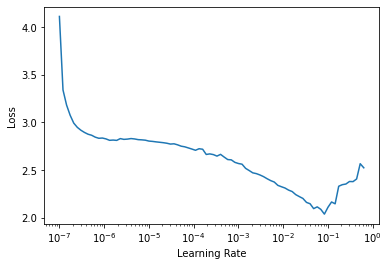

In [201]:
learn.lr_find()

In [204]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs128_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.302651,0.380037,0.625821,01:03


Better model found at epoch 0 with f1_score value: 0.6258206064437398.


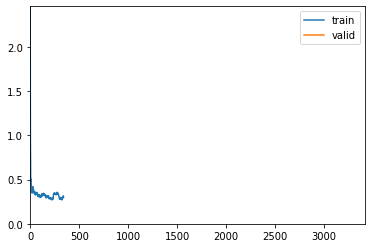

Better model found at epoch 0 with f1_score value: 0.6258206064437398.


In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [ ]:
model = LSTMModel(7936, 12, hidden_dim=256)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [ ]:
learn.lr_find()

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs256_v2'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [ ]:
model = LSTMModel(7936, 12)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs128_moreEpochs_v2'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [ ]:
learn.load("best_sequence_from_embs128_moreEpochs_v2")

In [ ]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [ ]:
evaluate(learn, dls.valid)

In [ ]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [ ]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [ ]:
torch.save(test_dl, "./data/test_dl_sequence_from_embs_v3.pth")

In [ ]:
evaluate(learn, test_dl)

In [ ]:
class BiLSTMCRF(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128, img_emb_dim=4096, text_emb_dim=3840):
        self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
        self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
        self.index= tensor(0).cuda()
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        self.crf = CRF(num_tags=out_dim, batch_first=True).cuda()
    
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        clean_targ = targ.clone()
        clean_targ[clean_targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        clean_targ=clean_targ.view(targ.shape)
        mask=mask.view(targ.shape)
        return -self.crf(out, clean_targ.long(), mask=mask, reduction="mean")
        
    def forward(self, img_act, text_act, img_none, text_none):
        img_act[img_none==1] = self.img_none_emb(self.index)
        text_act[text_none==1] = self.text_none_emb(self.index)
        x = torch.cat([img_act, text_act], axis=-1)
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [ ]:
model = BiLSTMCRF(7936, 12)

In [ ]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [ ]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [ ]:
learn.validate()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_128_v2'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [ ]:
model = BiLSTMCRF(7936, 12, hidden_dim=256)

In [ ]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [ ]:
learn.lr_find()

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_256_v2'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [ ]:
model = BiLSTMCRF(7936, 12)

In [ ]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_128_moreEpochs_v2'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [ ]:
learn.load("best_lstm_fromEmbs_crf_128_moreEpochs_v2")

In [ ]:
def evaluate_crf(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    crf_preds =[]
    crf_targs=[]
    for pred, targ in zip(preds, targets):
        pred = pred.unsqueeze(0)
        targ = targ.unsqueeze(0)
        mask = tensor(targ.data != OUT_DIM)
        mask=mask.view(pred.shape[:2])
        pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
        pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
        targ = targ[mask].view(-1)
        crf_preds.append(pred)
        crf_targs.append(targ)
    crf_preds = torch.cat(crf_preds)
    crf_targs = torch.cat(crf_targs)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab, digits=4))
    crf_preds = torch.remainder(crf_preds, 6)
    crf_targs = torch.remainder(crf_targs, 6)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab[:6], digits=4))
    

In [ ]:
evaluate_crf(learn, dls.valid)

In [ ]:
test_dl = torch.load("./data/test_dl_sequence_from_embs_v3.pth")

In [ ]:
evaluate_crf(learn, test_dl)